In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [4]:
raw_dataset = pd.read_csv("ghcnd_hcn/USC00447338_rem.csv")
dataset = raw_dataset.copy()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_dataset.dtypes

DATE    int64
PRCP    int64
TMAX    int64
TMIN    int64
SNOW    int64
SNWD    int64
dtype: object

In [5]:
train_stats = train_dataset.describe()
train_stats.pop("PRCP")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
DATE,4122.0,734313.941533,1951.026850,730805.0,732714.25,734127.5,736069.75,737378.0
TMAX,4122.0,208.145803,87.284120,-50.0,156.00,217.0,283.00,344.0
TMIN,4122.0,75.521106,88.458994,-167.0,6.00,83.0,161.00,211.0
SNOW,4122.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
SNWD,4122.0,1.352499,13.091606,0.0,0.00,0.0,0.00,178.0


In [6]:
train_labels = train_dataset.pop('PRCP')
test_labels = test_dataset.pop('PRCP')

In [7]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
print(train_dataset)
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

        DATE  TMAX  TMIN  SNOW  SNWD
1098  732502   294   161     0     0
311   731145   278   117     0     0
3488  735684    22   -72     0    51
1276  732710    -6   -94     0     0
3621  735817   317   178     0     0
...      ...   ...   ...   ...   ...
4497  736693   167    -6     0     0
3483  735679    22   -72     0    51
1591  733086    61   -78     0     0
3727  735923   156     0     0     0
3863  736059   206   133     0     0

[4122 rows x 5 columns]


In [8]:
normed_train_data = normed_train_data.drop(['SNOW'], axis=1)
normed_test_data = normed_test_data.drop(['SNOW'], axis=1)

In [9]:
normed_train_data

,DATE,TMAX,TMIN,SNWD
1098,-0.928712,0.983618,0.966311,-0.103310
311,-1.624243,0.800308,0.468905,-0.103310
3488,0.702224,-2.132642,-1.667678,3.792316
1276,-0.822101,-2.453434,-1.916381,-0.103310
3621,0.770394,1.247125,1.158490,-0.103310
...,...,...,...,...
4497,1.219388,-0.471401,-0.921569,-0.103310
3483,0.699662,-2.132642,-1.667678,3.792316
1591,-0.629382,-1.685826,-1.735506,-0.103310
3727,0.824724,-0.597426,-0.853741,-0.103310


In [10]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(normed_train_data.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model


In [11]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [12]:
example_batch = normed_train_data.values[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.03764471],
       [-0.05250575],
       [ 0.7593287 ],
       [ 0.15610412],
       [-0.01060746],
       [ 0.04941287],
       [ 0.3145298 ],
       [-0.15650362],
       [ 0.02973643],
       [ 0.23097678]], dtype=float32)

In [13]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:7882.1011,  mae:38.2354,  mse:7882.1011,  val_loss:9660.5479,  val_mae:45.9002,  val_mse:9660.5469,  
....................................................................................................
Epoch: 100, loss:4793.8896,  mae:43.5142,  mse:4793.8901,  val_loss:5963.1420,  val_mae:45.8485,  val_mse:5963.1411,  
....................................................................................................
Epoch: 200, loss:3261.5032,  mae:37.3724,  mse:3261.5027,  val_loss:3927.9185,  val_mae:40.8263,  val_mse:3927.9182,  
....................................................................................................
Epoch: 300, loss:2258.1912,  mae:32.2988,  mse:2258.1909,  val_loss:2536.1907,  val_mae:33.5140,  val_mse:2536.1907,  
....................................................................................................
Epoch: 400, loss:1608.4294,  mae:27.4137,  mse:1608.4292,  val_loss:1787.7777,  val_mae:28.1432,  val_mse:1787.7776,  
..

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,419.726733,13.855292,419.726715,996.705685,22.892311,996.705688,995
996,423.116219,13.697905,423.116333,879.859789,21.522228,879.859863,996
997,415.491880,13.426446,415.491882,367.033536,13.314830,367.033569,997
998,420.313722,13.617373,420.313843,383.893075,13.051879,383.893097,998
999,418.211491,13.517219,418.211517,453.550814,14.631036,453.550842,999


In [15]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [PRCP]')

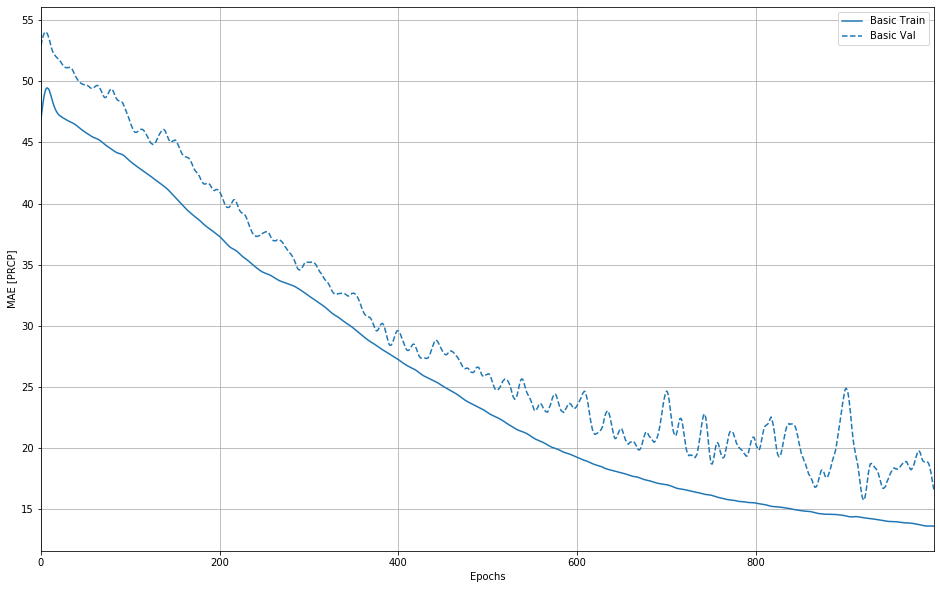

In [16]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [PRCP]')

In [17]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:7927.6507,  mae:38.1633,  mse:7927.6504,  val_loss:9773.2909,  val_mae:44.8695,  val_mse:9773.2900,  
....................................................................................................
Epoch: 100, loss:4318.2457,  mae:43.0846,  mse:4318.2446,  val_loss:5242.7932,  val_mae:44.6685,  val_mse:5242.7939,  
....................................................................................................
Epoch: 200, loss:2746.5690,  mae:34.3924,  mse:2746.5686,  val_loss:3345.3491,  val_mae:36.2485,  val_mse:3345.3491,  
....................................................................................................
Epoch: 300, loss:1643.4269,  mae:26.5954,  mse:1643.4272,  val_loss:1945.8980,  val_mae:27.9231,  val_mse:1945.8978,  
.................................................................................

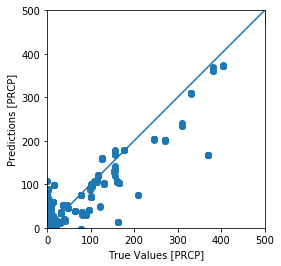

In [18]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [PRCP]')
plt.ylabel('Predictions [PRCP]')
lims = [0, 500]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

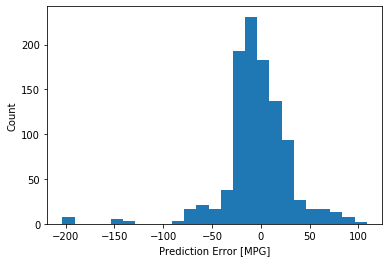

In [19]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

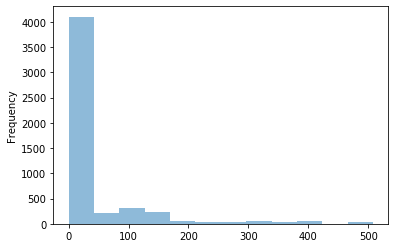

In [20]:
dataset['PRCP'].plot.hist(bins=12, alpha=0.5) 

ValueError: supplied range of [-inf, 6.230481447578482] is not finite

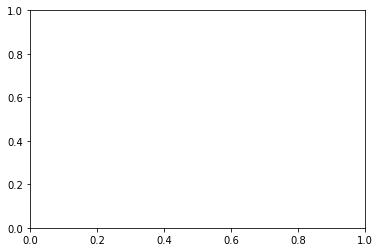

In [21]:
dataset["PRCP"].apply(np.log).hist()

In [ ]:
dataset.max()